In [3]:
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt

In [4]:
import os
import sys

spack_prefix = '/Users/shudler1/projects/asp/spack'
spack_lib_path = os.path.join(spack_prefix, "lib", "spack")
sys.path.insert(0, spack_lib_path)

spack_lib_path = os.path.join(spack_prefix, "lib", "spack")
sys.path.insert(0, spack_lib_path)

# Add external libs
spack_external_libs = os.path.join(spack_lib_path, "external")

if sys.version_info[:2] <= (2, 7):
    sys.path.insert(0, os.path.join(spack_external_libs, "py2"))
if sys.version_info[:2] == (2, 6):
    sys.path.insert(0, os.path.join(spack_external_libs, "py26"))

sys.path.insert(0, spack_external_libs)

if "ruamel.yaml" in sys.modules:
    del sys.modules["ruamel.yaml"]

if "ruamel" in sys.modules:
    del sys.modules["ruamel"]


In [5]:
import spack
import spack.binary_distribution
import spack.database as spack_db
import spack.util.spack_json as sjson

In [7]:
index_loc = spack.binary_distribution.binary_index_location()
with open(index_loc + '/e4s_packages.json', 'r') as f:
    limited_packs = sjson.load(f)

In [8]:
type(limited_packs)

list

In [9]:
len(limited_packs)

600

In [14]:
'adios244' in limited_packs

False

In [15]:
machine = 'lassen'
df_cache = []
df_cache.append(pd.read_csv('out_log_cache_1.csv'.format(machine), header=None, names=['pkg', 'cfg', 'iter', 'setup', 'load', 'ground', 'solve', 'total', 'dep_len']))
df_cache.append(pd.read_csv('out_log_cache_2.csv'.format(machine), header=None, names=['pkg', 'cfg', 'iter', 'setup', 'load', 'ground', 'solve', 'total', 'dep_len']))
df_cache.append(pd.read_csv('out_log_cache_3.csv'.format(machine), header=None, names=['pkg', 'cfg', 'iter', 'setup', 'load', 'ground', 'solve', 'total', 'dep_len']))
df_cache.append(pd.read_csv('out_log_cache_full.csv'.format(machine), header=None, names=['pkg', 'cfg', 'iter', 'setup', 'load', 'ground', 'solve', 'total', 'dep_len']))

In [16]:
packs = df_cache[0]['pkg']
pk_ls = sorted(list(set(packs)))
print(len(pk_ls))

5722


In [17]:
packs = set(limited_packs)
for df in df_cache:
    packs = packs.intersection(set(df['pkg']))
pk_ls = sorted(list(set(packs)))

In [18]:
print(len(pk_ls))

569


In [19]:
confs = df_cache[0]['cfg']
cfg_ls = list(set(confs))
print(cfg_ls)

[' tweety']


In [23]:
df = df_cache[0]
pk_ls[0]

'3dtk'

In [24]:
req_pk = df['pkg'] == pk_ls[0]
req_cf = df['cfg'] == cfg_ls[0]
df[req_pk & req_cf]

,pkg,cfg,iter,setup,load,ground,solve,total,dep_len
376,3dtk,tweety,0,18.160818,0.057241,2.456244,4.289618,25.648256,526
566,3dtk,tweety,1,22.391290,0.057643,2.640333,4.386225,30.138090,526
852,3dtk,tweety,2,17.517788,0.057377,2.491775,4.387487,25.114580,526


In [20]:
phases = ['setup', 'load', 'ground', 'solve', 'total']

In [21]:
timings_list = []

for df in df_cache:
    timings_list.append({})
    curr_timings = timings_list[-1]
    for cf in cfg_ls:
        curr_timings[cf] = {}
        for ph in phases:
            curr_timings[cf][ph] = []
        for pk in pk_ls:
            req_pk = df['pkg'] == pk
            req_cf = df['cfg'] == cf
            tdf = df[req_pk & req_cf]
            for ph in phases:
                curr_timings[cf][ph].append(tdf[ph].median())

In [42]:
min(timings_list[0][cfg_ls[0]]['total'])

0.6115331649780273

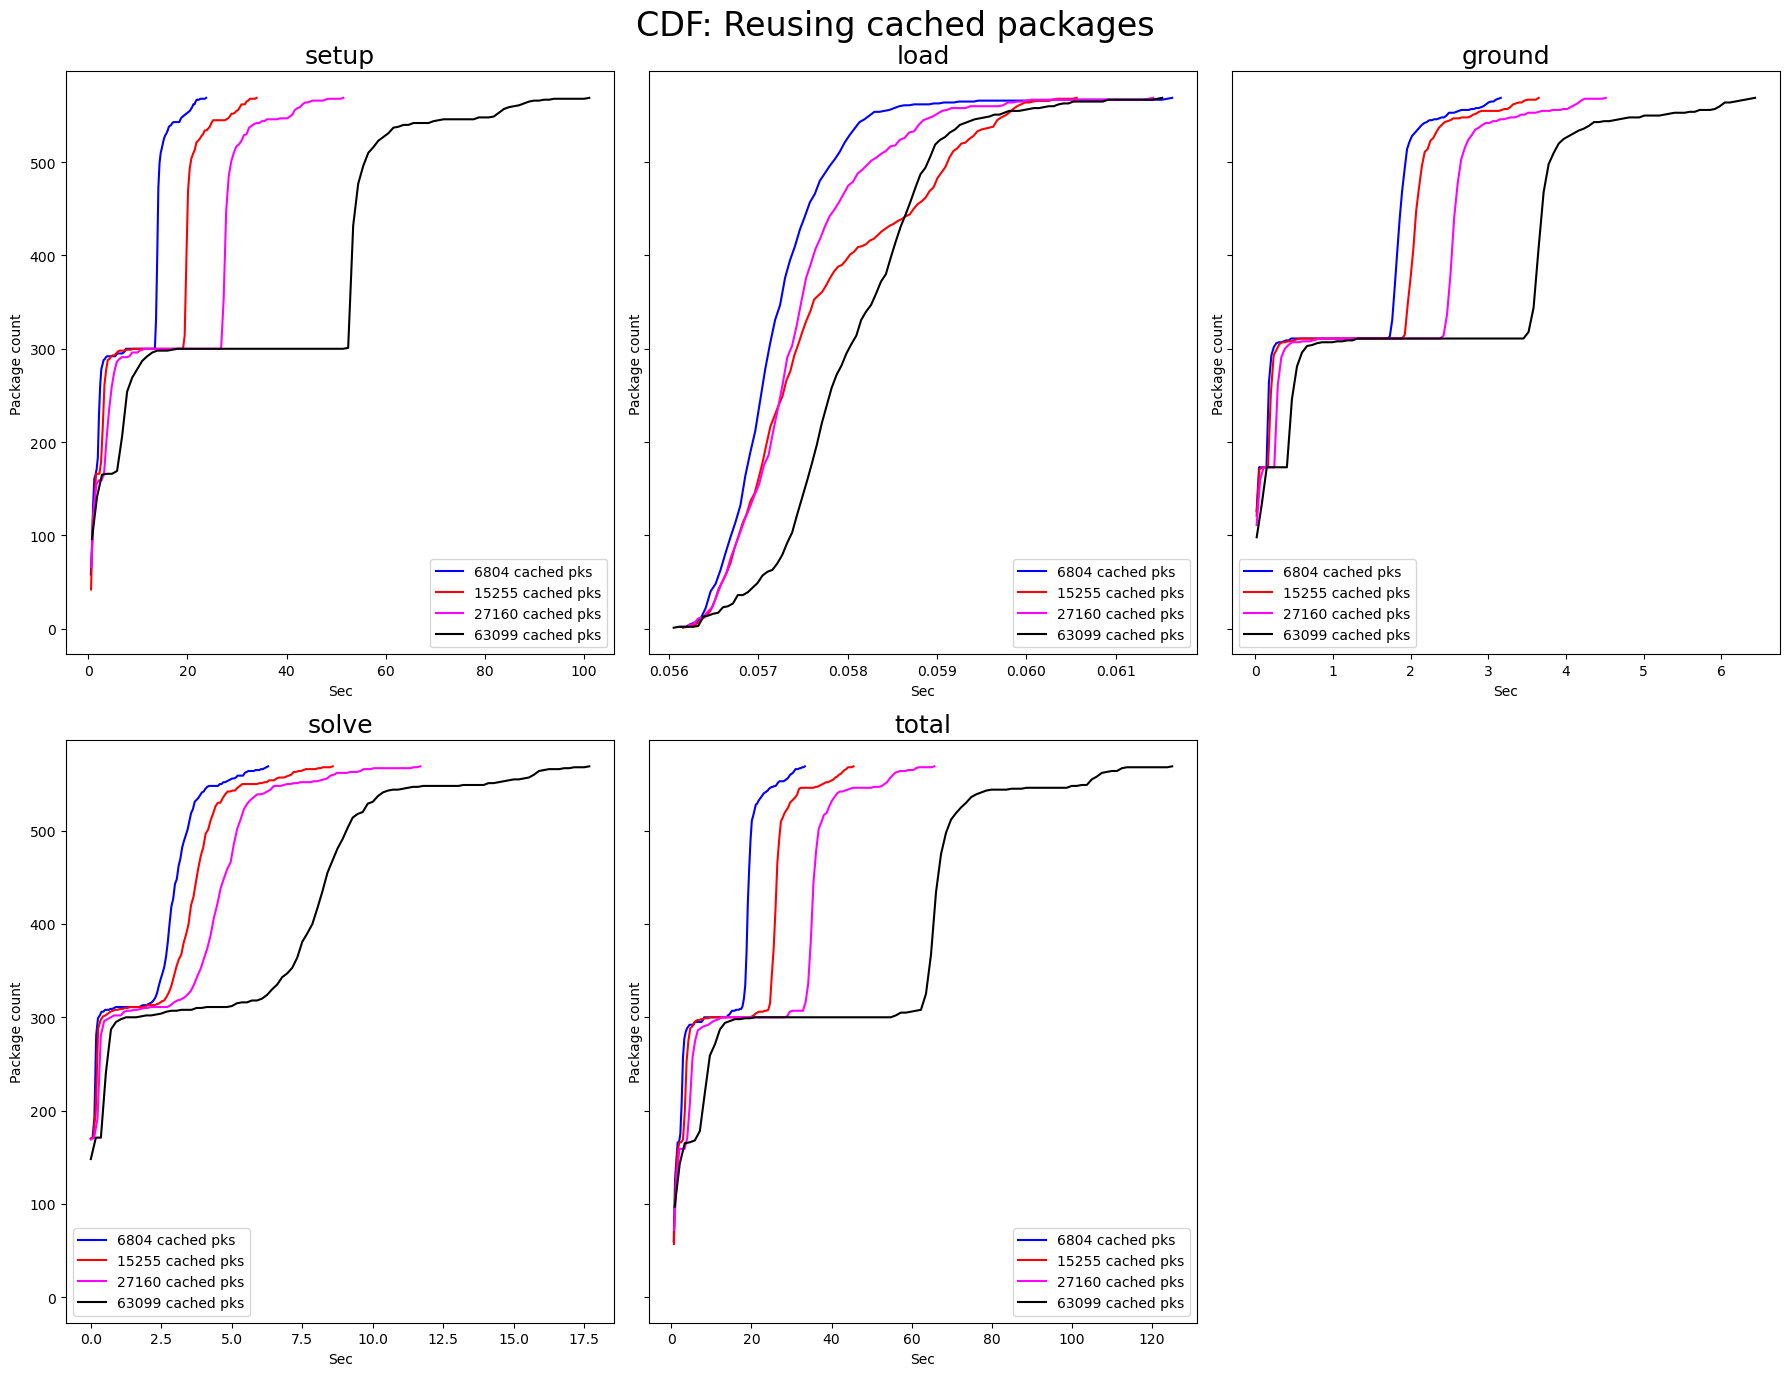

In [22]:
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True, figsize=(18,14), dpi=100)
axes = list(axs.flatten())
n_bins = 100

fig.suptitle('CDF: Reusing cached packages', fontsize=24)

axes[5].remove()

cfgs = [' tweety']
colors = ['blue', 'red', 'magenta', 'black']
labels = ['6804 cached pks', '15255 cached pks', '27160 cached pks', '63099 cached pks']

for i_tm, tms in enumerate(timings_list):
    for cf in cfgs:
        for i, ph in enumerate(phases):
            solve_times = sorted(zip(pk_ls, tms[cf][ph]), key=lambda x: x[1], reverse=True)
            tab_data = [[p, "{:.3f}".format(t)] for p, t in solve_times[0:5]]
            arr = np.array(sorted(tms[cf][ph], reverse=True))
            values, base = np.histogram(arr, bins=n_bins)
            cumulative = np.cumsum(values)
        #         print(solve_times[0:5])
        #         [p for p, t in solve_times[0:5]]

        #         axes[i].hist(sorted(tms[cf_base][ph], reverse=True), n_bins, label=ph, density=True, cumulative=True)
            axes[i].plot(base[:-1], cumulative, c=colors[i_tm], label=labels[i_tm])
#             if i_tm == 0:
#                 axes[i].plot(base[:-1], cumulative, c='blue', label='Tier 1')
        #        axes[i].hist(sorted(tms[cf_base][ph], reverse=True), n_bins, label=ph)
#             elif i_tm == 1:
#                 axes[i].plot(base[:-1], cumulative, c='red', label='Tier 2')
#             elif i_tm == 2:
#                 axes[i].plot(base[:-1], cumulative, c='magenta', label='Tier 3')
#             else:
#                 axes[i].plot(base[:-1], cumulative, c='black', label='Tier 3')
    #             axes[i].hist(sorted(tms[cf_base][ph], reverse=True), n_bins, label=ph, density=True, cumulative=True, c='blue', label='single-shot')
            axes[i].legend(fontsize='medium')
        #         tab = axes[i].table(cellText=[["{:.3f}".format(t) for p, t in solve_times[0:5]], [p for p, t in solve_times[0:5]]],
        #                       rowLabels=['times', 'pkg'],
            axes[i].set_title(ph, fontsize=18)
            axes[i].set_xlabel('Sec')
            axes[i].set_ylabel('Package count')
            axes[i].title.set_text(ph)
#         tab = axes[i].table(cellText=tab_data, bbox=[0.1, -0.5, 0.75, 0.4])
#         tab.auto_set_font_size(False)
#         tab.auto_set_column_width(col=[0, 1])
#         tab.set_fontsize(12)
# plt.show()
plt.savefig('cdf_e4s_pkgs_caches_{0}_fig.png'.format(machine), dpi=150)